# LucusRAG Evaluation: Precision & Recall at Different K Values

This notebook evaluates the RAG system's retrieval performance using precision and recall metrics at various top-k values.

## Metrics
- **Precision@k**: What fraction of retrieved documents are relevant?
- **Recall@k**: What fraction of relevant documents were retrieved?
- **F1@k**: Harmonic mean of precision and recall
- **MRR (Mean Reciprocal Rank)**: How early does the first relevant document appear?
- **NDCG@k**: Normalized Discounted Cumulative Gain (considers ranking quality)


In [114]:
import sys
import os
import json
import asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Set, Tuple
from collections import defaultdict

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from dotenv import load_dotenv
load_dotenv()

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [154]:
SAVE_TO="~/Documents/"
ALGORITHM = "VectorSearchOnly"
# Save detailed results
from pathlib import Path

# Expand ~ to home directory
des = Path(SAVE_TO).expanduser() / ALGORITHM
des.mkdir(parents=True, exist_ok=True)
print(f"{des} created or already exists")

/home/sam/Documents/VectorSearchOnly created or already exists


## 1. Load Test Queries


In [115]:
# Load test queries with ground truth
with open('test_queries.json', 'r') as f:
    test_queries = json.load(f)

print(f"Loaded {len(test_queries)} test queries")
print("\nQuery categories:")
categories = defaultdict(int)
for q in test_queries:
    categories[q['category']] += 1
for cat, count in categories.items():
    print(f"  {cat}: {count} queries")


Loaded 30 test queries

Query categories:
  simple_lookup: 1 queries
  configuration: 1 queries
  api_endpoint: 1 queries
  data_model: 1 queries
  provider_usage: 1 queries
  enumeration: 1 queries
  database: 1 queries
  parsing: 1 queries
  error_handling: 1 queries
  utility: 1 queries
  transformation: 1 queries
  pipeline_flow: 1 queries
  embeddings_pipeline: 1 queries
  incremental_update: 1 queries
  resilience: 1 queries
  concurrency: 1 queries
  parsing_pipeline: 1 queries
  vector_indexing: 1 queries
  formatting: 1 queries
  request_flow: 1 queries
  end_to_end_pipeline: 1 queries
  graph_relationships: 1 queries
  lifecycle_management: 1 queries
  ai_explanation_pipeline: 1 queries
  hybrid_retrieval: 1 queries
  file_processing_lifecycle: 1 queries
  error_handling_system: 1 queries
  schema_management: 1 queries
  system_initialization: 1 queries
  concurrency_control: 1 queries


## 2. Initialize RAG System


In [116]:
from rag.indexer.orchestrator import CodeGraphIndexer
from rag.engine.engine import make_query_engine
from rag.schemas.vector_config import VectorIndexConfig
from rag.indexer.vector_indexer import create_vector_index_from_existing_nodes 



# Verify environment configuration
print("Environment Configuration:")
print(f"  LLM_PROVIDER: {os.getenv('LLM_PROVIDER', 'NOT SET (will default to anthropic)')}")
print(f"  LLM_MODEL: {os.getenv('LLM_MODEL', 'NOT SET (will use default)')}")
print(f"  EMBEDDING_PROVIDER: {os.getenv('EMBEDDING_PROVIDER', 'NOT SET (will default to voyage)')}")
print(f"  LLM_MAX_OUTPUT_TOKENS: {os.getenv('LLM_MAX_OUTPUT_TOKENS', 'NOT SET (will default to 768)')}")
print()

# Initialize the indexer
ast_cache_dir = os.getenv('AST_CACHE_DIR', '../ast_cache/results_tree-sitter')
indexer = CodeGraphIndexer(ast_cache_dir=ast_cache_dir, top_k=20)

# Build or refresh the index
print("Initializing RAG system...")
result = await indexer.build()
print(f"Build completed: {result}")


Environment Configuration:
  LLM_PROVIDER: openai
  LLM_MODEL: gpt-4o-mini
  EMBEDDING_PROVIDER: openai
  LLM_MAX_OUTPUT_TOKENS: 768

Initializing RAG system...
Build completed: [BUILD] 62 docs | 0.11s | schema v1


## 3. Define Evaluation Metrics


In [117]:
def precision_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate precision@k: fraction of retrieved docs that are relevant."""
    if k == 0 or len(retrieved) == 0:
        return 0.0
    retrieved_k = retrieved[:k]
    relevant_retrieved = sum(1 for doc in retrieved_k if doc in relevant)
    return relevant_retrieved / len(retrieved_k)

def recall_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate recall@k: fraction of relevant docs that were retrieved."""
    if len(relevant) == 0:
        return 0.0
    retrieved_k = retrieved[:k]
    relevant_retrieved = sum(1 for doc in retrieved_k if doc in relevant)
    return relevant_retrieved / len(relevant)

def f1_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate F1@k: harmonic mean of precision and recall."""
    p = precision_at_k(retrieved, relevant, k)
    r = recall_at_k(retrieved, relevant, k)
    if p + r == 0:
        return 0.0
    return 2 * (p * r) / (p + r)

def mean_reciprocal_rank(retrieved: List[str], relevant: Set[str]) -> float:
    """Calculate MRR: 1/rank of first relevant document."""
    for i, doc in enumerate(retrieved, 1):
        if doc in relevant:
            return 1.0 / i
    return 0.0

def dcg_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate Discounted Cumulative Gain@k."""
    dcg = 0.0
    for i, doc in enumerate(retrieved[:k], 1):
        relevance = 1.0 if doc in relevant else 0.0
        dcg += relevance / np.log2(i + 1)
    return dcg

def ndcg_at_k(retrieved: List[str], relevant: Set[str], k: int) -> float:
    """Calculate Normalized DCG@k."""
    dcg = dcg_at_k(retrieved, relevant, k)
    # Ideal DCG: all relevant docs at the top
    ideal_retrieved = [1] * min(len(relevant), k)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(len(ideal_retrieved)))
    if idcg == 0:
        return 0.0
    return dcg / idcg

print("Evaluation metrics defined successfully")


Evaluation metrics defined successfully


## 4. Retrieval Function


In [118]:
print(type(indexer._engine.retriever))

<class 'llama_index.core.indices.vector_store.retrievers.retriever.VectorIndexRetriever'>


In [119]:
# Use orchestrator's retrieve_documents method
async def retrieve_documents(query: str, k: int = 20) -> List[Dict]:
    """Retrieve top-k documents for a query using the orchestrator.
    
    Returns list of dicts with:
    - node_id: unique identifier
    - file_path: source file
    - element_type: type of code element
    - element_name: name of code element
    - score: similarity score
    - text: document content preview
    """
    return await indexer.retrieve_documents(query, k=k)

print("Retrieval function ready")


Retrieval function ready


## 5. Run Evaluation

This cell runs the evaluation across all test queries at multiple k values.


In [132]:
# K values to test
k_values = [1, 3, 5, 10, 15, 20]

# Storage for results
all_results = []

print("Running evaluation...\n")

for i, query_data in enumerate(test_queries, 1):
    query = query_data['query']
    relevant_files = set(query_data['relevant_files'])
    relevant_elements = set(query_data['relevant_elements'])
    category = query_data['category']
    
    print(f"[{i}/{len(test_queries)}] {query}")
    
    # Retrieve documents (max k=20)
    retrieved = await retrieve_documents(query, k=max(k_values))
    
    # Extract element names from text (metadata fields are 'unknown')
    retrieved_elements = []
    
    for r in retrieved:
        text = r['text']
        # Parse: "Name: X\n"
        name = None
        file_path = None
        for line in text.split('\n')[:3]:
            if line.startswith('Name: '):
                name = line.replace('Name: ', '').strip()
        if name:
            retrieved_elements.append(name)
    
    # Calculate metrics for each k
    for k in k_values:
        # Element-level metrics
        p_elem = precision_at_k(retrieved_elements, relevant_elements, k)
        r_elem = recall_at_k(retrieved_elements, relevant_elements, k)
        f1_elem = f1_at_k(retrieved_elements, relevant_elements, k)
        ndcg_elem = ndcg_at_k(retrieved_elements, relevant_elements, k)
        
        all_results.append({
            'query': query,
            'category': category,
            'k': k,
            'precision_elements': p_elem,
            'recall_elements': r_elem,
            'f1_elements': f1_elem,
            'ndcg_elements': ndcg_elem,
        })
    
    # MRR (independent of k)
    mrr_elem = mean_reciprocal_rank(retrieved_elements, relevant_elements)
    print(f"  MRR (elements): {mrr_elem:.3f}")
    print()

# Convert to DataFrame
df_results = pd.DataFrame(all_results)
print(f"\nEvaluation complete! Analyzed {len(test_queries)} queries at {len(k_values)} k values.")
df_results.head(10)


Running evaluation...

[1/30] What is the VoyageEmbedding class used for?
  MRR (elements): 0.000

[2/30] How do I configure Neo4j connection?
  MRR (elements): 0.071

[3/30] What does the health check endpoint return?
  MRR (elements): 0.000

[4/30] What is the CodeElement dataclass?
  MRR (elements): 0.000

[5/30] How do I get an Anthropic LLM instance?
  MRR (elements): 0.083

[6/30] What LLM providers are supported?
  MRR (elements): 0.000

[7/30] What is the GraphDBManager class?
  MRR (elements): 0.000

[8/30] What parsers are available for code?
  MRR (elements): 0.100

[9/30] What is the QueryProcessingError exception?
  MRR (elements): 0.000

[10/30] How do I create a progress tracker?
  MRR (elements): 0.000

[11/30] How are code elements converted to graph nodes?
  MRR (elements): 0.000

[12/30] How does the query processing pipeline work?
  MRR (elements): 0.091

[13/30] How are embeddings generated and stored in Neo4j?
  MRR (elements): 0.000

[14/30] How does the incremen

,query,category,k,precision_elements,recall_elements,f1_elements,ndcg_elements
0,What is the VoyageEmbedding class used for?,simple_lookup,1,0.0,0.0,0.0,0.0
1,What is the VoyageEmbedding class used for?,simple_lookup,3,0.0,0.0,0.0,0.0
2,What is the VoyageEmbedding class used for?,simple_lookup,5,0.0,0.0,0.0,0.0
3,What is the VoyageEmbedding class used for?,simple_lookup,10,0.0,0.0,0.0,0.0
4,What is the VoyageEmbedding class used for?,simple_lookup,15,0.0,0.0,0.0,0.0
5,What is the VoyageEmbedding class used for?,simple_lookup,20,0.0,0.0,0.0,0.0
6,How do I configure Neo4j connection?,configuration,1,0.0,0.0,0.0,0.0
7,How do I configure Neo4j connection?,configuration,3,0.0,0.0,0.0,0.0
8,How do I configure Neo4j connection?,configuration,5,0.0,0.0,0.0,0.0
9,How do I configure Neo4j connection?,configuration,10,0.0,0.0,0.0,0.0


## 6. Aggregate Results


In [133]:
# Aggregate by k value
agg_by_k = df_results.groupby('k').agg({
    'precision_elements': 'mean',
    'recall_elements': 'mean',
    'f1_elements': 'mean',
    'ndcg_elements': 'mean',
}).round(3)

print("\n=== Average Metrics by K Value ===")
print(agg_by_k)

# Aggregate by category
agg_by_category = df_results.groupby(['category', 'k']).agg({
    'precision_elements': 'mean',
    'recall_elements': 'mean',
    'f1_elements': 'mean',
}).round(3)

print("\n=== Average Metrics by Category and K ===")
print(agg_by_category)



=== Average Metrics by K Value ===
    precision_elements  recall_elements  f1_elements  ndcg_elements
k                                                                  
1                0.033            0.011        0.017          0.033
3                0.011            0.011        0.011          0.016
5                0.013            0.017        0.014          0.021
10               0.027            0.067        0.037          0.044
15               0.027            0.125        0.043          0.063
20               0.027            0.155        0.044          0.075

=== Average Metrics by Category and K ===
                            precision_elements  recall_elements  f1_elements
category                k                                                   
ai_explanation_pipeline 1                0.000            0.000        0.000
                        3                0.000            0.000        0.000
                        5                0.000            0.000      

## 7. Visualizations


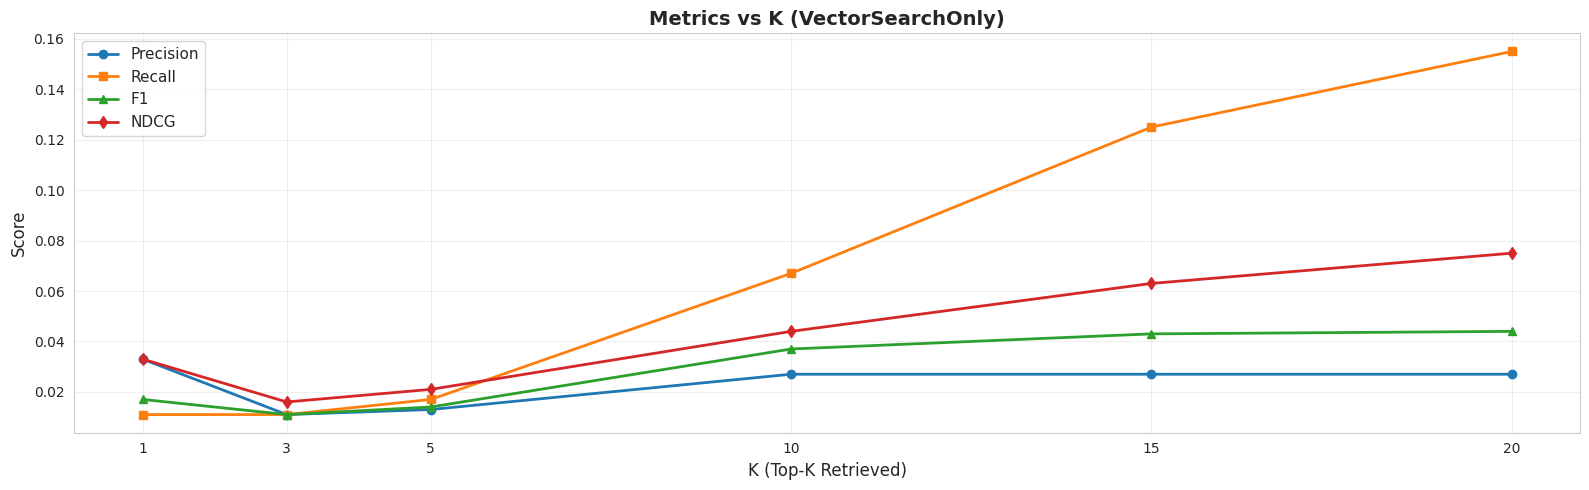

Saved: metrics_vs_k.png


In [159]:
# Plot 1: Precision, Recall, F1 vs K
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
# Element-level metrics
ax.plot(agg_by_k.index, agg_by_k['precision_elements'], marker='o', label='Precision', linewidth=2)
ax.plot(agg_by_k.index, agg_by_k['recall_elements'], marker='s', label='Recall', linewidth=2)
ax.plot(agg_by_k.index, agg_by_k['f1_elements'], marker='^', label='F1', linewidth=2)
ax.plot(agg_by_k.index, agg_by_k['ndcg_elements'], marker='d', label='NDCG', linewidth=2)
ax.set_xlabel('K (Top-K Retrieved)', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Metrics vs K ({ALGORITHM})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)

plt.tight_layout()
plt.savefig(des /'metrics_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: metrics_vs_k.png")


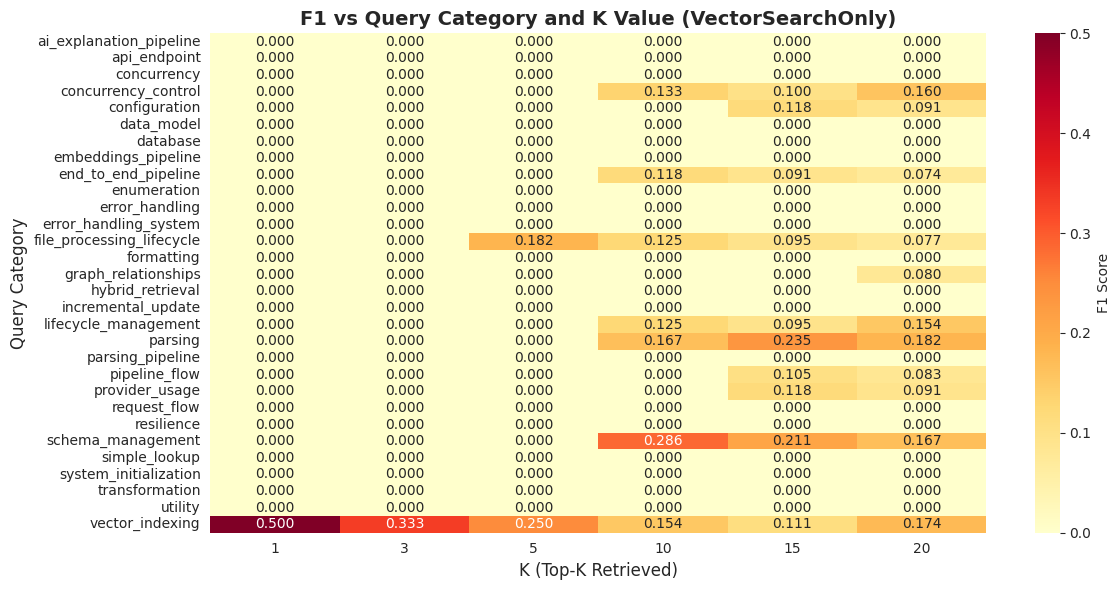

Saved: f1_heatmap.png


In [158]:
# Plot 2: Heatmap of F1 scores by category and K
pivot_f1 = df_results.pivot_table(
    values='f1_elements',
    index='category',
    columns='k',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'F1 Score'})
plt.title(F'F1 vs Query Category and K Value ({ALGORITHM})', fontsize=14, fontweight='bold')
plt.xlabel('K (Top-K Retrieved)', fontsize=12)
plt.ylabel('Query Category', fontsize=12)
plt.tight_layout()
plt.savefig(des/'f1_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: f1_heatmap.png")


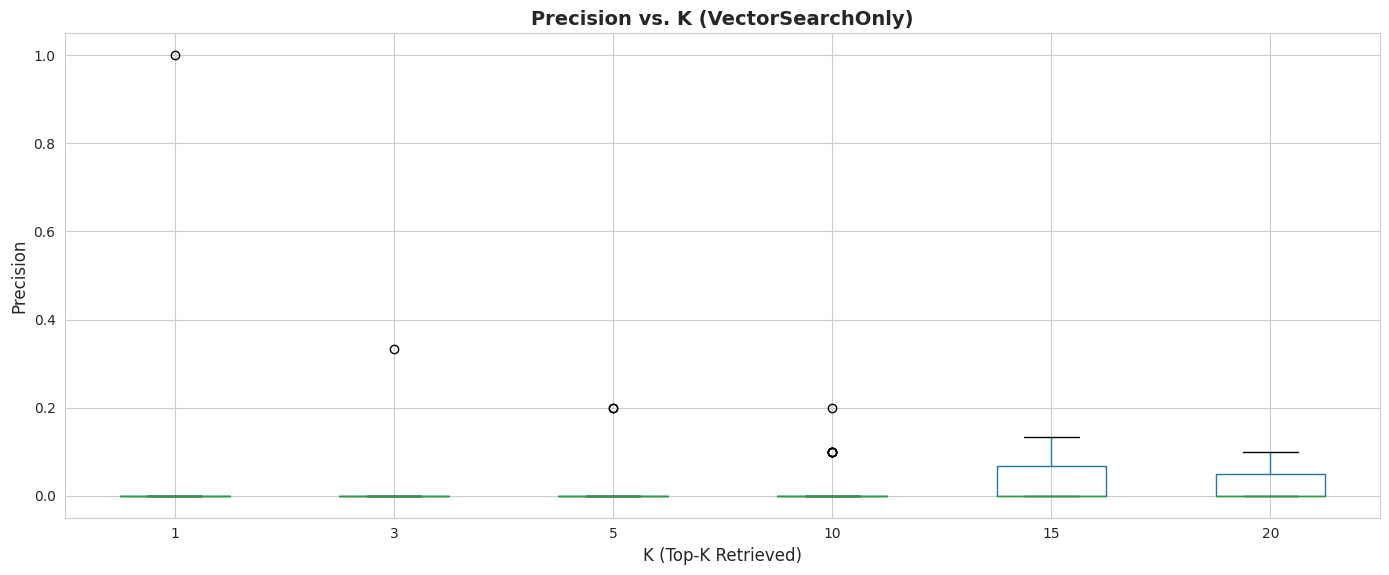

Saved: precision_distribution.png


In [157]:
# Plot 3: Box plot of precision distribution by K
fig, ax = plt.subplots(figsize=(14, 6))
df_results.boxplot(column='precision_elements', by='k', ax=ax)
ax.set_xlabel('K (Top-K Retrieved)', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(f'Precision vs. K ({ALGORITHM})', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig(des / 'precision_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: precision_distribution.png")


## 8. Best/Worst Queries Analysis


In [137]:
# Find best and worst performing queries at k=5
df_k5 = df_results[df_results['k'] == 5].copy()

# Best queries (by F1)
best_queries = df_k5.nlargest(3, 'f1_elements')[['query', 'category', 'precision_elements', 'recall_elements', 'f1_elements']]
print("\n=== Top 3 Best Performing Queries (k=5) ===")
print(best_queries.to_string(index=False))

# Worst queries (by F1)
worst_queries = df_k5.nsmallest(3, 'f1_elements')[['query', 'category', 'precision_elements', 'recall_elements', 'f1_elements']]
print("\n=== Top 3 Worst Performing Queries (k=5) ===")
print(worst_queries.to_string(index=False))



=== Top 3 Best Performing Queries (k=5) ===
                                                                    query                  category  precision_elements  recall_elements  f1_elements
                  How does the vector index get created from Neo4j nodes?           vector_indexing                 0.2         0.333333     0.250000
How are AST files processed, stored, and tracked for incremental updates? file_processing_lifecycle                 0.2         0.166667     0.181818
                              What is the VoyageEmbedding class used for?             simple_lookup                 0.0         0.000000     0.000000

=== Top 3 Worst Performing Queries (k=5) ===
                                      query      category  precision_elements  recall_elements  f1_elements
What is the VoyageEmbedding class used for? simple_lookup                 0.0              0.0          0.0
       How do I configure Neo4j connection? configuration                 0.0              0.

## 9. Save Results


In [160]:
# Save detailed results
df_results.to_csv(des / 'evaluation_results.csv', index=False)
print("Saved: evaluation_results.csv")

# Save aggregate metrics
agg_by_k.to_csv(des / 'metrics_by_k.csv')
print("Saved: metrics_by_k.csv")

# Save summary report
with open(des / 'evaluation_summary.txt', 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("LucusRAG Evaluation Summary\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"Total Queries: {len(test_queries)}\n")
    f.write(f"K Values Tested: {k_values}\n\n")
    
    f.write("Average Metrics by K Value:\n")
    f.write("-" * 80 + "\n")
    f.write(agg_by_k.to_string())
    f.write("\n\n")
    
    f.write("Best Configuration:\n")
    f.write("-" * 80 + "\n")
    best_k = agg_by_k['f1_elements'].idxmax()
    f.write(f"Optimal K: {best_k}\n")
    f.write(f"F1 Score: {agg_by_k.loc[best_k, 'f1_elements']:.3f}\n")
    f.write(f"Precision: {agg_by_k.loc[best_k, 'precision_elements']:.3f}\n")
    f.write(f"Recall: {agg_by_k.loc[best_k, 'recall_elements']:.3f}\n")
    f.write(f"NDCG: {agg_by_k.loc[best_k, 'ndcg_elements']:.3f}\n")

print("Saved: evaluation_summary.txt")
print("\n" + "=" * 80)
print("Evaluation complete! All results saved.")
print("=" * 80)


Saved: evaluation_results.csv
Saved: metrics_by_k.csv
Saved: evaluation_summary.txt

Evaluation complete! All results saved.


## 10. Recommendations

Based on the evaluation results:

1. **Optimal K Value**: Review `metrics_by_k.csv` to find the K value that balances precision and recall
2. **Weak Categories**: Examine categories with low F1 scores in the heatmap
3. **Retrieval Quality**: Use NDCG scores to assess ranking quality
4. **System Tuning**:
   - Adjust similarity threshold in `SimilarityPostprocessor`
   - Experiment with different embedding models
   - Consider query expansion techniques for low-recall queries
   - Add re-ranking layers for better precision
